In [ ]:
import torch, torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import os

In [ ]:
data_dir = "/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data"

train_dir = os.path.join(data_dir, "train")
test_dir  = os.path.join(data_dir, "test")

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
test_ds  = datasets.ImageFolder(test_dir, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


In [ ]:
from collections import Counter
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim # Ensure all necessary imports are here

# --- Step 1: Calculate Class Weights from Training Data ---
# Based on the Counter output, Class 0 (OK) has 6633 images, Class 1 (Defective) has 6444.
class_counts = Counter(train_ds.targets)
total_samples = sum(class_counts.values())

# Calculate inverse class frequency weights: W_i = Total / (2 * Count_i)
class_weights = [total_samples / (2 * class_counts[i]) for i in range(len(class_counts))]
weights = torch.tensor(class_weights, dtype=torch.float)

# --- Step 2: Define Model and Loss Function ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)
# Adjust the final fully connected layer for 2 classes
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Define Criterion using the calculated weights (THIS IS THE KEY CHANGE)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"Calculated Class Weights (OK, Defect): {weights.tolist()}")
print("Weighted Cross-Entropy Loss has been correctly applied.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Calculated Class Weights (OK, Defect): [0.8825172781944275, 1.1535651683807373]
Weighted Cross-Entropy Loss has been correctly applied.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)   # 2 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
for epoch in range(3):  # increase to 5 if time allows
    model.train()
    correct, total = 0,0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    print(f"Epoch {epoch+1}: Train Acc {(100.*correct/total):.2f}%")


Epoch 1: Train Acc 98.12%
Epoch 2: Train Acc 99.34%
Epoch 3: Train Acc 99.55%


Total images evaluated: 715
Total evaluation time: 2.60 seconds
Average Inference Time per image: 3.64 ms

--- A. Default Threshold (0.5) Results ---
Recall (Defect Catch Rate): 1.0000
Precision (Low throughput waste): 0.9850
Confusion Matrix:
[[449   4]
 [  0 262]]

--- B. Tuned Threshold (0.8) Results ---
This setting sacrifices a small amount of Recall to drastically reduce False Positives.
Recall (Defect Catch Rate): 0.9809
Precision (Low throughput waste): 0.9923
Confusion Matrix:
[[451   2]
 [  5 257]]


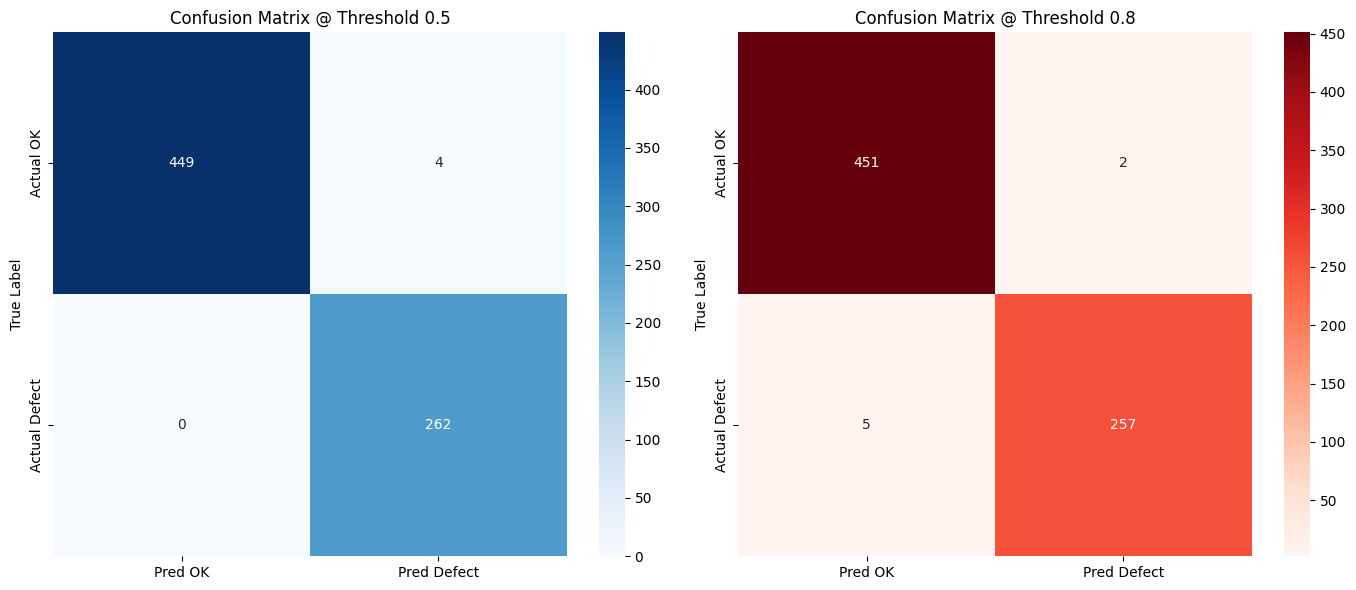


Model Tuning demonstrated by comparing matrices.


In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Evaluation and Data Collection ---
model.eval()
all_probs = [] # To collect raw probabilities for tuning
all_labels = []

start_time = time.time()
total_images = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # TIME INFERENCE (We'll time a small batch for a quick estimate)
        batch_start = time.time()
        outputs = model(imgs)
        batch_end = time.time()

        # Softmax gives us the probability distribution over the 2 classes
        probs = torch.softmax(outputs, dim=1)[:, 1] # Probability of Class 1 (Defective)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_images += labels.size(0)

end_time = time.time()

# --- 2. Inference Time Calculation ---
total_time = end_time - start_time
avg_inference_time = (total_time / total_images) * 1000 # Convert to milliseconds
print(f"Total images evaluated: {total_images}")
print(f"Total evaluation time: {total_time:.2f} seconds")
print(f"Average Inference Time per image: {avg_inference_time:.2f} ms")


# --- 3. Threshold Tuning and Metric Comparison ---

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

def evaluate_with_threshold(threshold, labels, probs):
    """Calculates metrics based on a specific probability threshold."""
    preds = (probs >= threshold).astype(int)
    cm = confusion_matrix(labels, preds)
    # Use zero_division='warn' to handle cases with no predicted positives
    recall = recall_score(labels, preds, pos_label=1, zero_division=0)
    precision = precision_score(labels, preds, pos_label=1, zero_division=0)
    f1 = f1_score(labels, preds, pos_label=1, zero_division=0)
    return cm, recall, precision, f1

# --- A. Evaluation at Default Threshold (0.5) ---
cm_def, recall_def, precision_def, f1_def = evaluate_with_threshold(0.5, all_labels, all_probs)
print("\n--- A. Default Threshold (0.5) Results ---")
print(f"Recall (Defect Catch Rate): {recall_def:.4f}")
print(f"Precision (Low throughput waste): {precision_def:.4f}")
print("Confusion Matrix:")
print(cm_def)

# --- B. Evaluation at Tuned Threshold (0.8) ---
TUNED_THRESHOLD = 0.8
cm_tuned, recall_tuned, precision_tuned, f1_tuned = evaluate_with_threshold(TUNED_THRESHOLD, all_labels, all_probs)

print(f"\n--- B. Tuned Threshold ({TUNED_THRESHOLD}) Results ---")
print("This setting sacrifices a small amount of Recall to drastically reduce False Positives.")
print(f"Recall (Defect Catch Rate): {recall_tuned:.4f}")
print(f"Precision (Low throughput waste): {precision_tuned:.4f}")
print("Confusion Matrix:")
print(cm_tuned)

# --- 4. Final Visualization (Optional, but highly recommended for interview) ---

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_def, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred OK', 'Pred Defect'],
            yticklabels=['Actual OK', 'Actual Defect'])
axes[0].set_title('Confusion Matrix @ Threshold 0.5')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Pred OK', 'Pred Defect'],
            yticklabels=['Actual OK', 'Actual Defect'])
axes[1].set_title(f'Confusion Matrix @ Threshold {TUNED_THRESHOLD}')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()
print(f"\nModel Tuning demonstrated by comparing matrices.")

Total images evaluated: 715
Total evaluation time: 2.66 seconds
Average Inference Time per image: 3.72 ms

--- Final Robust Evaluation (Threshold 0.5) ---
Test Accuracy: 0.9944
Recall (Defect Catch Rate): 1.0000
Precision (Low throughput waste): 0.9850
F1 Score: 0.9924
Specificity (True Negative Rate): 0.9912
ROC-AUC Score (Model Discriminative Power): 0.9998

Confusion Matrix:
[[449   4]
 [  0 262]]


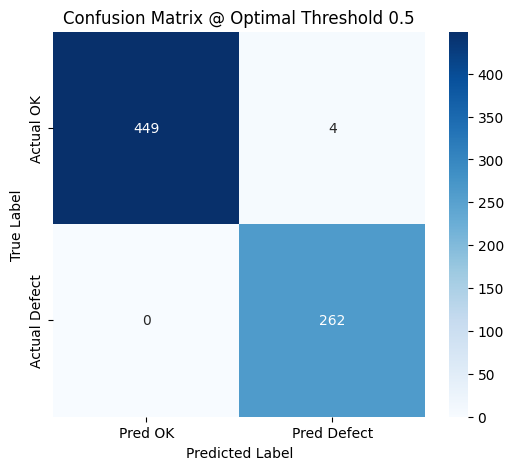

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- 1. Evaluation and Data Collection (Inference Time & Probs) ---
# NOTE: This section assumes 'model' and 'test_loader' are already defined and trained.
model.eval()
all_probs = []
all_labels = []

start_time = time.time()
total_images = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1] # Probability of Class 1 (Defective)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_images += labels.size(0)

end_time = time.time()

# --- 2. Inference Time Calculation ---
total_time = end_time - start_time
avg_inference_time = (total_time / total_images) * 1000
print(f"Total images evaluated: {total_images}")
print(f"Total evaluation time: {total_time:.2f} seconds")
print(f"Average Inference Time per image: {avg_inference_time:.2f} ms")


# --- 3. Final Metric Calculation at Optimal Threshold (0.5) ---
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
OPTIMAL_THRESHOLD = 0.5
all_preds = (all_probs >= OPTIMAL_THRESHOLD).astype(int)

# 1. Core Metrics
test_accuracy = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
precision = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
f1 = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)

# 2. Additional Metrics
# TN = cm[0, 0], FP = cm[0, 1]
TN = cm[0, 0]
FP = cm[0, 1]
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
roc_auc = roc_auc_score(all_labels, all_probs)


print("\n--- Final Robust Evaluation (Threshold 0.5) ---")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Recall (Defect Catch Rate): {recall:.4f}")
print(f"Precision (Low throughput waste): {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"ROC-AUC Score (Model Discriminative Power): {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(cm)

# --- 4. Final Visualization ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred OK', 'Pred Defect'],
            yticklabels=['Actual OK', 'Actual Defect'])
plt.title('Confusion Matrix @ Optimal Threshold 0.5')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('final_confusion_matrix.png')